In [1]:
## import stuff

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import tensorflow as tf
import random
import matplotlib.pyplot as plt

%matplotlib inline
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gc 

In [2]:
gc.collect()

132

In [3]:
## import the tablular data info

data_train = pd.read_csv('~/Downloads/siim-isic-melanoma-classification/train.csv')
data_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## look at image data

In [15]:
os.chdir('../../Downloads/siim-isic-melanoma-classification/')
data_dir = 'jpeg/train/'
train_files = os.listdir(data_dir)

In [16]:
len(train_files)

33126

In [17]:
## dict of the image and its target
data_train.image_name = data_train.image_name.astype(str) + str('.jpg')
target_dict = pd.Series(data_train.target.values, index = data_train.image_name).to_dict()

In [18]:
## list of melanoma and not melanoma images
ls_melanoma = []
ls_no_melanoma = []
for k,v in target_dict.items():
    if v == 1:
        ls_melanoma.append(k)
    if v == 0:
        ls_no_melanoma.append(k)

In [19]:
random.choice(ls_no_melanoma)

'ISIC_5320483.jpg'

In [20]:
gc.collect()

68

## Body Hair Analysis - blackhat filter

In [21]:
import cv2

In [29]:
def hair_remove(image):
    kernel = cv2.getStructuringElement(1,(15,15)) 
    # Reading the image named 'input.jpg' 
    input_image = cv2.imread(image) 
    ## resize the image
    #image_resize = cv2.resize(input_image,(512,512))
    ## blacknwhite
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    # Applying the Black-Hat operation 
    tophat_img = cv2.morphologyEx(input_image_gray
                                  , cv2.MORPH_BLACKHAT
                                  , kernel)
    ## threshold the image to increase the hair intensity
    ret,thresh_img = cv2.threshold(tophat_img,10,255,cv2.THRESH_BINARY)
    ## remove it 
    pre_out = cv2.inpaint(input_image,thresh_img,1,cv2.INPAINT_TELEA)
    ## convert back to rgb 
    out = cv2.cvtColor(pre_out, cv2.COLOR_BGR2RGB)
    return out

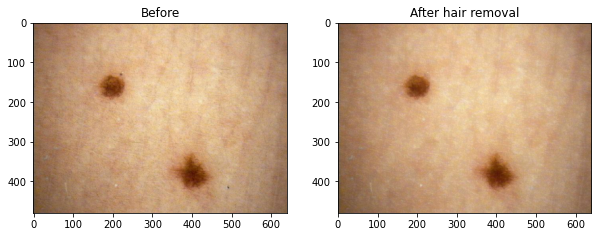

In [30]:
pic = os.path.join(data_dir, random.choice(ls_no_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

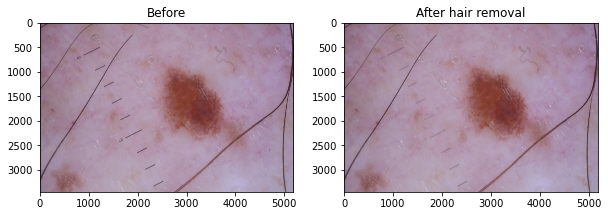

In [31]:
pic = os.path.join(data_dir, random.choice(ls_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

## Augmentation

- use image generator
- pass a custom augmentation func to remove hair in images 

In [32]:
## make new directory
! mkdir 'train_w_class'

In [33]:
## create class directories
! mkdir 'train_w_class/no_melanoma'
! mkdir 'train_w_class/melanoma'
melanoma_dir = 'train_w_class/melanoma'
no_melanoma_dir = 'train_w_class/no_melanoma'

In [34]:
## move images to class specific directories

## creating no melanoma dir
for i in ls_no_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(no_melanoma_dir, i))
    

## creating melanoma dir
for i in ls_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(melanoma_dir, i))

## Image loading and Augmentation

In [35]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## some additional data augmentation
training_datagen = ImageDataGenerator(
    rescale = 1./255
    , rotation_range=40
    , width_shift_range=0.2 
    , height_shift_range=0.2 
    , zoom_range=0.2
    , horizontal_flip=True
    , fill_mode='nearest'
    , preprocessing_function=hair_remove)

## utilize the new directory structure to infer classes
train_generator = training_datagen.flow_from_directory(
    'train_w_class'
    , target_size=(512,512)
    , class_mode='binary'
    , batch_size=100
)

Found 33126 images belonging to 2 classes.


## Transfer Learning model - 

## Testing
- preprocess the test images
    - resize
- predict and create a submission csv